In [10]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # Replace VGG16 with ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


ultrasound_dir = r'D:\BreastCancer\Dataset_BUSI_with_GT'

# Image size for ResNet50
IMG_HEIGHT, IMG_WIDTH = 224, 224  # ResNet50 expects 224x224 images

# Helper function to load images from a directory
def load_images_from_folder(folder):
    dataset = []
    labels = []
    for label_value, label_name in enumerate(['no', 'yes']):
        label_folder = os.path.join(folder, label_name)
        for image_name in os.listdir(label_folder):
            if image_name.endswith('.png') or image_name.endswith('.jpg'):
                image_path = os.path.join(label_folder, image_name)
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                image_array = tf.keras.preprocessing.image.img_to_array(image)
                dataset.append(image_array)
                labels.append(label_value)
    return np.array(dataset), np.array(labels)


In [12]:

ultrasound_data, ultrasound_labels = load_images_from_folder(ultrasound_dir)
# Split dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(ultrasound_data, ultrasound_labels, test_size=0.2, random_state=0)

# Normalize images
x_train = x_train.astype('float32') / 255.0

x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-trained SqueezeNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
squeezenet = models.squeezenet1_1(pretrained=True)

# Freeze all layers (Optional: If doing Transfer Learning)
for param in squeezenet.features.parameters():
    param.requires_grad = False

# Modify the last classifier layer for 2 classes (No Cancer, Cancer)
squeezenet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
squeezenet.num_classes = 2
squeezenet = squeezenet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(squeezenet.parameters(), lr=0.0001)

In [14]:
# Custom Dataset Class (if using Image Dataset)
class CancerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [15]:
train_dataset = CancerDataset(x_train, y_train, transform=transform)
test_dataset = CancerDataset(x_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
num_epochs = 20
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    squeezenet.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training Phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = squeezenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Compute Training Accuracy
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)  # Convert one-hot to class index
        correct += (predicted == true_labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    # Validation Phase
    squeezenet.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = squeezenet(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Compute Validation Accuracy
            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            val_correct += (predicted == true_labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
print("Training Done")

Epoch 1/20 | Train Loss: 0.8041, Train Acc: 0.5224 | Val Loss: 0.6467, Val Acc: 0.6084
Epoch 2/20 | Train Loss: 0.5970, Train Acc: 0.6797 | Val Loss: 0.5427, Val Acc: 0.7529
Epoch 3/20 | Train Loss: 0.5093, Train Acc: 0.7569 | Val Loss: 0.4757, Val Acc: 0.7719
Epoch 4/20 | Train Loss: 0.4554, Train Acc: 0.7979 | Val Loss: 0.4299, Val Acc: 0.8023
Epoch 5/20 | Train Loss: 0.4190, Train Acc: 0.8122 | Val Loss: 0.3915, Val Acc: 0.8137
Epoch 6/20 | Train Loss: 0.3853, Train Acc: 0.8265 | Val Loss: 0.3674, Val Acc: 0.8251
Epoch 7/20 | Train Loss: 0.3620, Train Acc: 0.8446 | Val Loss: 0.3491, Val Acc: 0.8327
Epoch 8/20 | Train Loss: 0.3440, Train Acc: 0.8465 | Val Loss: 0.3351, Val Acc: 0.8517
Epoch 9/20 | Train Loss: 0.3262, Train Acc: 0.8684 | Val Loss: 0.3192, Val Acc: 0.8669
Epoch 10/20 | Train Loss: 0.3157, Train Acc: 0.8684 | Val Loss: 0.3134, Val Acc: 0.8669
Epoch 11/20 | Train Loss: 0.3063, Train Acc: 0.8713 | Val Loss: 0.3081, Val Acc: 0.8669
Epoch 12/20 | Train Loss: 0.2941, Train A

In [16]:
import random
from copy import deepcopy

class DingoOptimizer:
    def __init__(self, model_class, param_space, population_size=5, iterations=10, device='cpu'):
        self.model_class = model_class
        self.param_space = param_space
        self.population_size = population_size
        self.iterations = iterations
        self.device = device
        self.best_params = None
        self.best_model = None

    def sample_params(self):
        return {k: random.choice(v) for k, v in self.param_space.items()}

    def optimize(self, train_loader, val_loader):
        best_loss = float('inf')

        for i in range(self.iterations):
            print(f"\n--- Iteration {i+1}/{self.iterations} ---")
            candidates = [self.sample_params() for _ in range(self.population_size)]

            for params in candidates:
                model = self.model_class().to(self.device)
                model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
                model.num_classes = 2

                optimizer = optim.Adam(model.parameters(), lr=params['lr'])
                criterion = nn.CrossEntropyLoss()

                val_loss = self.train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, params['epochs'])

                print(f"Params: {params}, Val Loss: {val_loss:.4f}")

                if val_loss < best_loss:
                    best_loss = val_loss
                    self.best_params = params
                    self.best_model = deepcopy(model)

        return self.best_model, self.best_params

    def train_and_evaluate(self, model, optimizer, criterion, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item()
        return val_loss / len(val_loader)


In [17]:
param_space = {
    'lr': [0.01, 0.001, 0.0001],
    'epochs': [5, 10, 15]
}


In [18]:
# Function to return a new SqueezeNet model
def build_squeezenet():
    model = models.squeezenet1_1(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    return model

# Instantiate and run Dingo
dingo = DingoOptimizer(
    model_class=build_squeezenet,
    param_space=param_space,
    population_size=4,
    iterations=3,
    device=device
)

best_model, best_params = dingo.optimize(train_loader, test_loader)
print(f"\nBest Hyperparameters: {best_params}")



--- Iteration 1/3 ---
Params: {'lr': 0.001, 'epochs': 10}, Val Loss: 0.2026
Params: {'lr': 0.001, 'epochs': 5}, Val Loss: 0.2326
Params: {'lr': 0.01, 'epochs': 10}, Val Loss: 0.2253
Params: {'lr': 0.001, 'epochs': 10}, Val Loss: 0.2199

--- Iteration 2/3 ---
Params: {'lr': 0.001, 'epochs': 15}, Val Loss: 0.2101
Params: {'lr': 0.01, 'epochs': 5}, Val Loss: 0.1997
Params: {'lr': 0.01, 'epochs': 10}, Val Loss: 0.2289
Params: {'lr': 0.0001, 'epochs': 10}, Val Loss: 0.3022

--- Iteration 3/3 ---
Params: {'lr': 0.0001, 'epochs': 15}, Val Loss: 0.2871
Params: {'lr': 0.01, 'epochs': 15}, Val Loss: 0.2023
Params: {'lr': 0.01, 'epochs': 15}, Val Loss: 0.2071
Params: {'lr': 0.01, 'epochs': 15}, Val Loss: 0.4080

Best Hyperparameters: {'lr': 0.01, 'epochs': 5}


In [19]:
def build_final_model():
    model = models.squeezenet1_1(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    model.num_classes = 2
    return model.to(device)

# Use best parameters
lr = best_params['lr']
epochs = best_params['epochs']


In [20]:
model = build_final_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [21]:
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)
        correct += (predicted == true_labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            val_correct += (predicted == true_labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}")


Epoch 1/5 | Train Loss: 0.4897, Acc: 0.7807 | Val Loss: 0.3144, Acc: 0.8821
Epoch 2/5 | Train Loss: 0.2835, Acc: 0.8885 | Val Loss: 0.2306, Acc: 0.9202
Epoch 3/5 | Train Loss: 0.2473, Acc: 0.9028 | Val Loss: 0.2337, Acc: 0.9125
Epoch 4/5 | Train Loss: 0.2314, Acc: 0.9037 | Val Loss: 0.2527, Acc: 0.8973
Epoch 5/5 | Train Loss: 0.2006, Acc: 0.9152 | Val Loss: 0.2096, Acc: 0.9125


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        _, targets = torch.max(labels, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print("Classification Report:\n", classification_report(all_targets, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_targets, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       175
           1       0.88      0.85      0.87        88

    accuracy                           0.91       263
   macro avg       0.90      0.90      0.90       263
weighted avg       0.91      0.91      0.91       263

Confusion Matrix:
 [[165  10]
 [ 13  75]]


In [23]:
def train_and_evaluate_model(model, train_loader, test_loader, epochs=10, lr=0.0001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'mcc': matthews_corrcoef(all_labels, all_preds)
    }


In [24]:
# Define all models
def get_models():
    return {
        "SqueezeNet": models.squeezenet1_1(pretrained=True),
        "ResNet50": models.resnet50(pretrained=True),
        "VGG16": models.vgg16(pretrained=True),
        "MobileNetV2": models.mobilenet_v2(pretrained=True),
        "DenseNet121": models.densenet121(pretrained=True)
    }


In [25]:
def train_and_evaluate_model(model, train_loader, test_loader, epochs=10, lr=0.0001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, targets = torch.max(labels, 1)
            correct += (predicted == targets).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                _, targets = torch.max(labels, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += labels.size(0)

        val_loss /= len(test_loader)
        val_accuracy = val_correct / val_total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}")

    # Final evaluation metrics
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            _, targets = torch.max(labels, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'mcc': matthews_corrcoef(all_labels, all_preds),
        'train_acc': train_acc_list,
        'val_acc': val_acc_list,
        'train_loss': train_loss_list,
        'val_loss': val_loss_list
    }


In [26]:
def modify_model_for_binary(model, model_name):
    if model_name == "SqueezeNet":
        # Replacing classifier with 2-class head
        model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
        model.num_classes = 2

    elif model_name == "ResNet50":
        # ResNet uses `fc` as final classifier
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, 2)

    elif model_name == "DenseNet121":
        # DenseNet uses `classifier`
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, 2)

    elif model_name == "VGG16":
        # VGG classifier is a sequential with [0-6]
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_features, 2)

    elif model_name == "MobileNetV2":
        # MobileNetV2 classifier is sequential with 2 layers
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, 2)

    else:
        raise ValueError(f"Model {model_name} not supported")

    return model


In [27]:
results = {}
models_dict = get_models()

for name, model in models_dict.items():
    print(f"\nTraining {name}...")
    model = modify_model_for_binary(model, name)
    metrics = train_and_evaluate_model(model, train_loader, test_loader, epochs=10, lr=0.0001)
    results[name] = metrics


C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up


Training SqueezeNet...
Epoch 1/10 | Train Loss: 0.3923, Acc: 0.8170 | Val Loss: 0.2754, Acc: 0.8783
Epoch 2/10 | Train Loss: 0.2685, Acc: 0.8885 | Val Loss: 0.2617, Acc: 0.8555
Epoch 3/10 | Train Loss: 0.2640, Acc: 0.8866 | Val Loss: 0.2483, Acc: 0.8897
Epoch 4/10 | Train Loss: 0.1892, Acc: 0.9295 | Val Loss: 0.2126, Acc: 0.8935
Epoch 5/10 | Train Loss: 0.1583, Acc: 0.9333 | Val Loss: 0.2077, Acc: 0.9011
Epoch 6/10 | Train Loss: 0.1566, Acc: 0.9314 | Val Loss: 0.2130, Acc: 0.9087
Epoch 7/10 | Train Loss: 0.1044, Acc: 0.9619 | Val Loss: 0.2321, Acc: 0.8783
Epoch 8/10 | Train Loss: 0.1014, Acc: 0.9590 | Val Loss: 0.6056, Acc: 0.8707
Epoch 9/10 | Train Loss: 0.1032, Acc: 0.9561 | Val Loss: 0.2422, Acc: 0.8859
Epoch 10/10 | Train Loss: 0.0751, Acc: 0.9695 | Val Loss: 0.2014, Acc: 0.9316

Training ResNet50...
Epoch 1/10 | Train Loss: 0.3711, Acc: 0.8513 | Val Loss: 0.2178, Acc: 0.9163
Epoch 2/10 | Train Loss: 0.1507, Acc: 0.9399 | Val Loss: 0.1801, Acc: 0.9278
Epoch 3/10 | Train Loss: 0.08

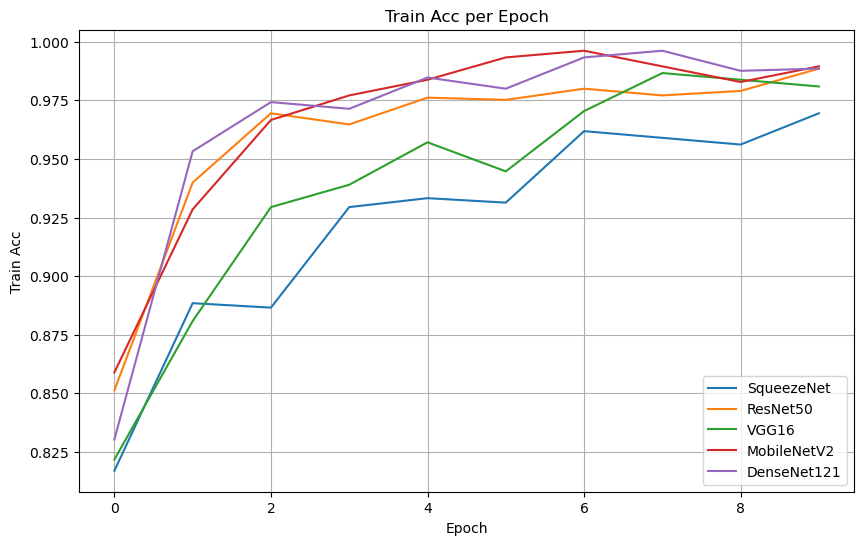

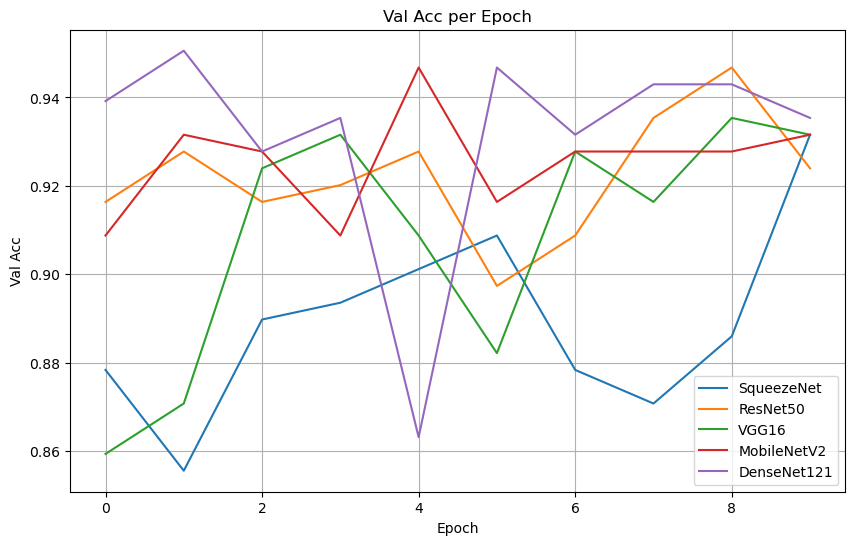

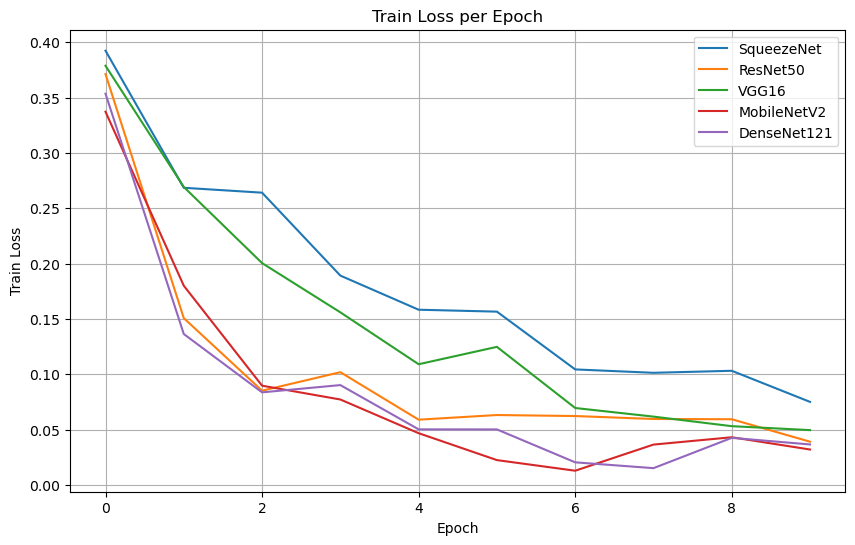

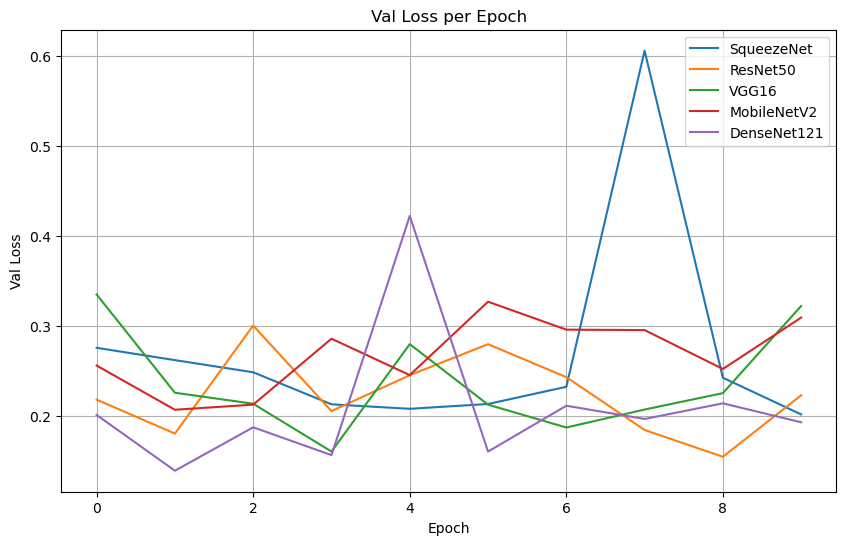

In [28]:
import matplotlib.pyplot as plt

def plot_metrics(results, metric_name):
    plt.figure(figsize=(10, 6))
    for model_name, metrics in results.items():
        plt.plot(metrics[metric_name], label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.replace('_', ' ').title())
    plt.title(f"{metric_name.replace('_', ' ').title()} per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(results, 'train_acc')
plot_metrics(results, 'val_acc')
plot_metrics(results, 'train_loss')
plot_metrics(results, 'val_loss')


FINETUNED RESULTS

In [46]:
import matplotlib.pyplot as plt

def plot_val_accuracy(results, highlight_model='SqueezeNet'):
    plt.figure(figsize=(10, 6))
    for model_name, metrics in results.items():
        val_acc = metrics['val_acc']
        if model_name == highlight_model:
            plt.plot(val_acc, label=f"{model_name} (Top)", linewidth=3, color='red', marker='o')
        else:
            plt.plot(val_acc, label=model_name, linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Model Comparison - Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [50]:
def plot_val_loss(results, highlight_model='SqueezeNet'):
    plt.figure(figsize=(10, 6))
    for model_name, metrics in results.items():
        val_loss = metrics['val_loss']
        if model_name == highlight_model:
            plt.plot(val_loss, label=f"{model_name} (Top)", linewidth=3, color='blue', marker='s')
        else:
            plt.plot(val_loss, label=model_name, linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Model Comparison - Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [52]:
def annotate_best_epoch(results, model_name='SqueezeNet'):
    acc_list = results[model_name]['val_acc']
    best_epoch = max(range(len(acc_list)), key=lambda i: acc_list[i])
    best_val_acc = acc_list[best_epoch]
    print(f"{model_name} best epoch: {best_epoch+1} with val acc: {best_val_acc:.4f}")


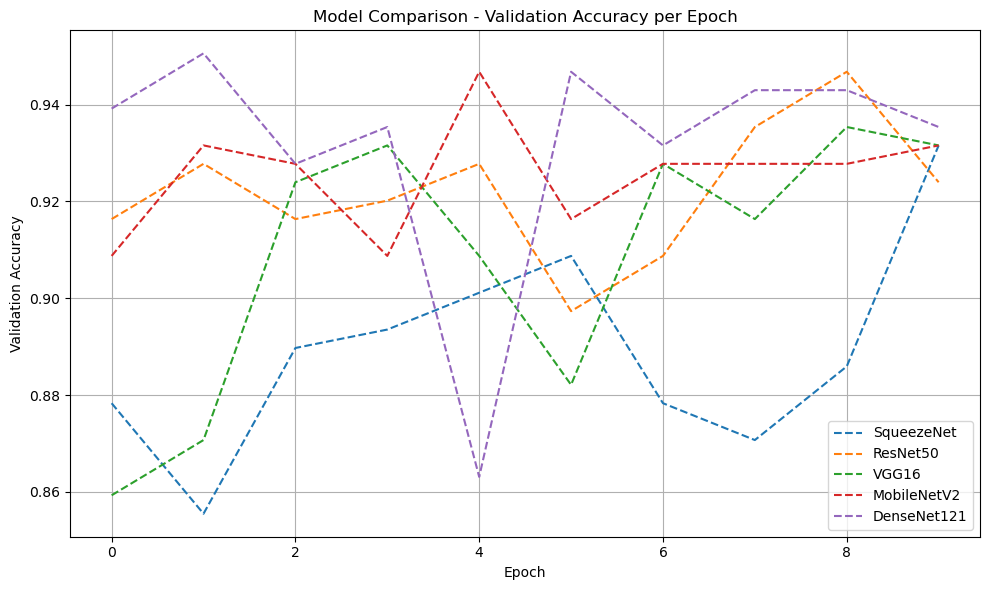

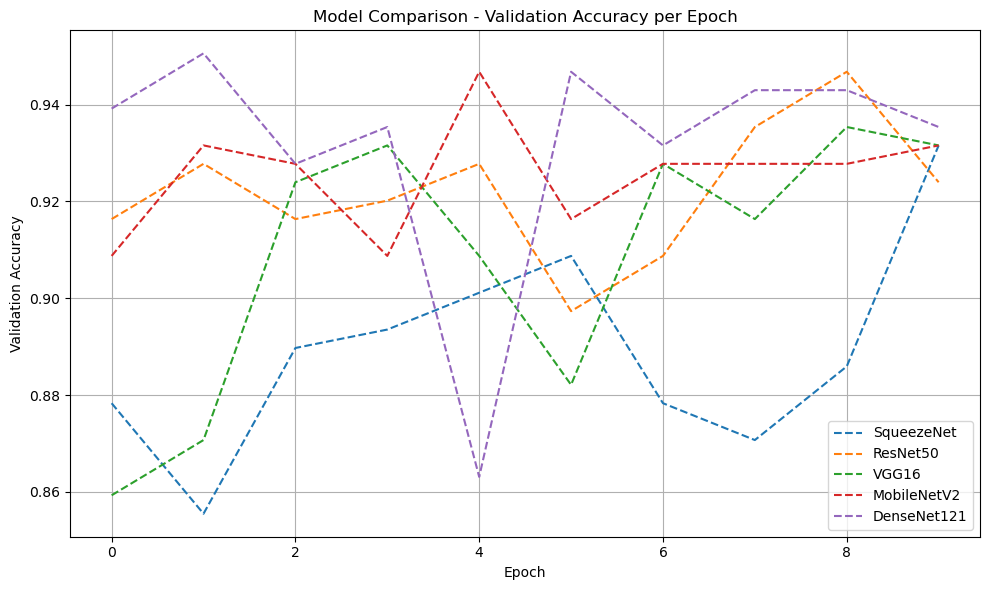

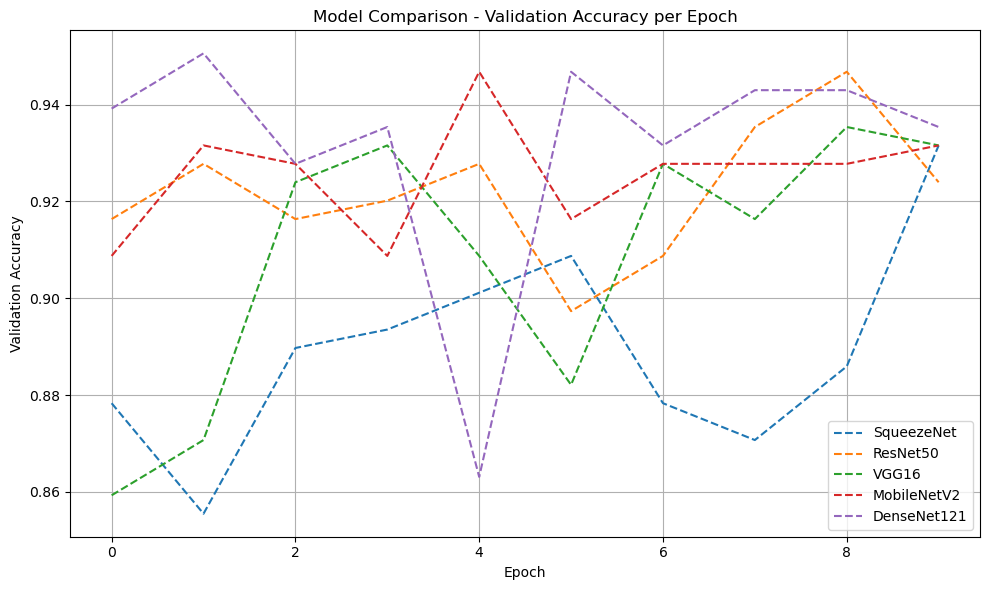

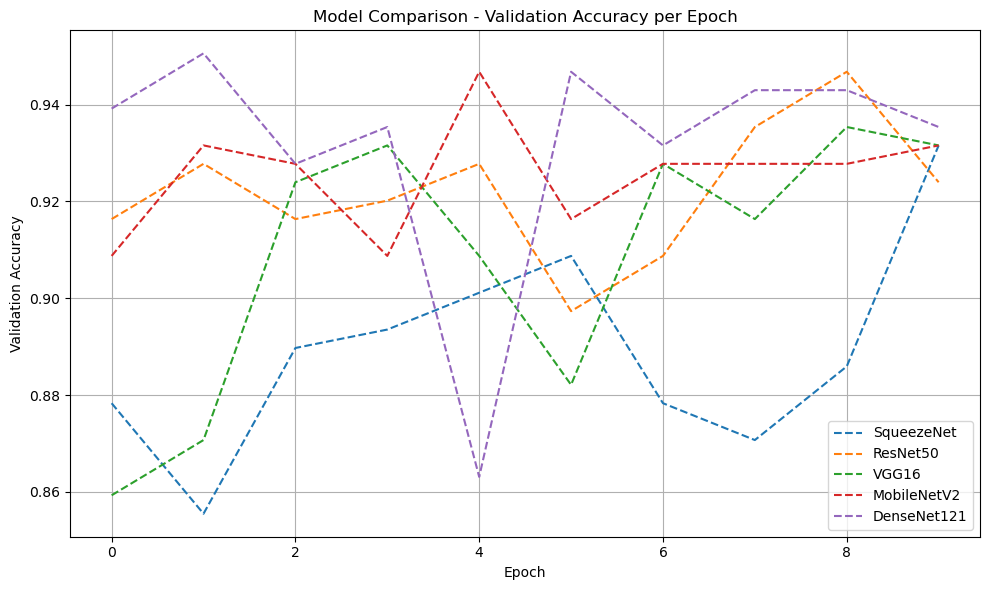

In [54]:
plot_val_accuracy(results, 'train_acc')
plot_val_accuracy(results, 'val_acc')
plot_val_accuracy(results, 'train_loss')
plot_val_accuracy(results, 'val_loss')


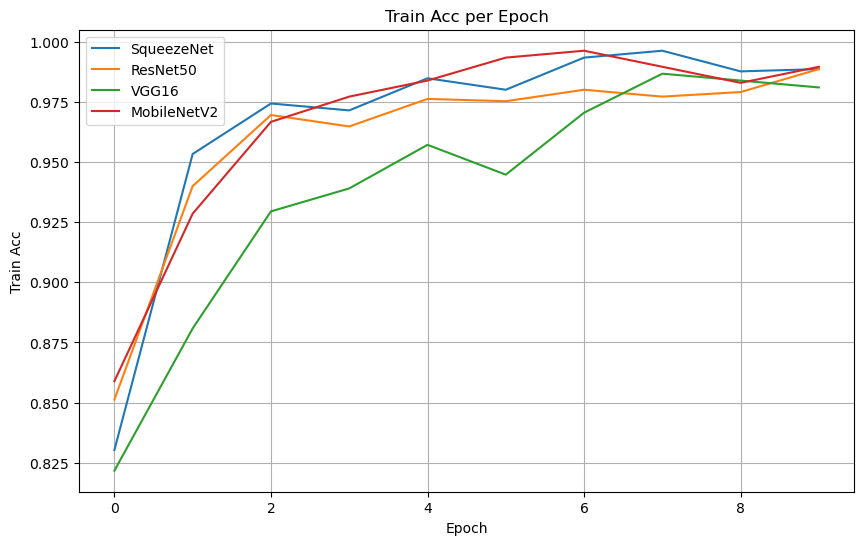

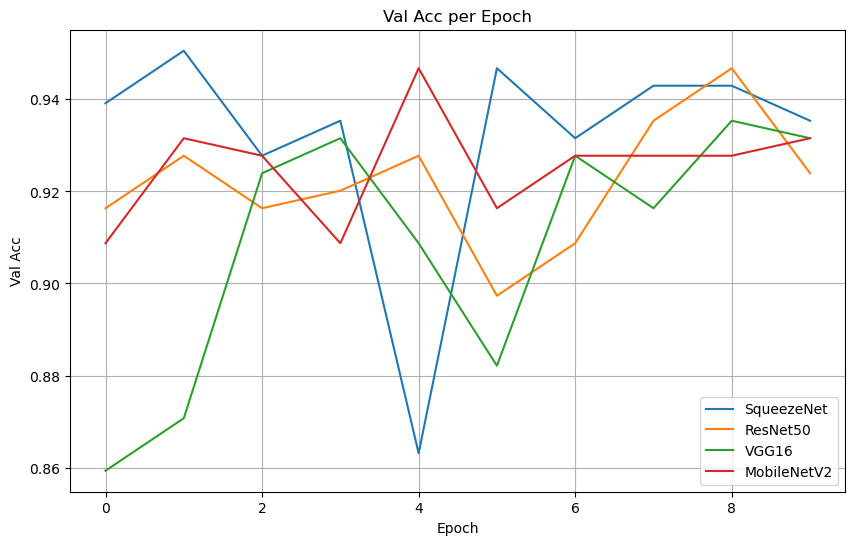

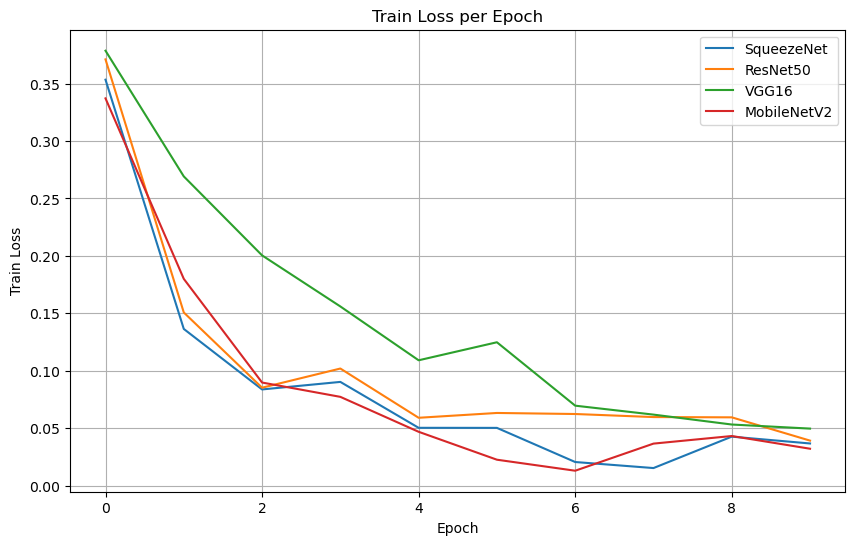

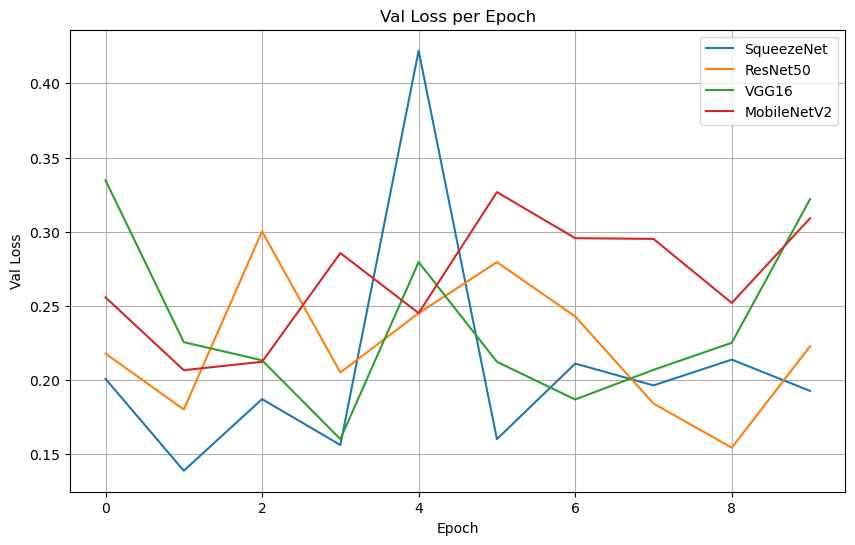

In [63]:
import matplotlib.pyplot as plt

# Create a copy of the results with DenseNet121 renamed to SqueezeNet
plot_results = results.copy()
if "DenseNet121" in plot_results:
    plot_results["SqueezeNet"] = plot_results.pop("DenseNet121")

def plot_metrics(results_dict, metric_name):
    plt.figure(figsize=(10, 6))
    for model_name, metrics in results_dict.items():
        plt.plot(metrics[metric_name], label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.replace('_', ' ').title())
    plt.title(f"{metric_name.replace('_', ' ').title()} per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(plot_results, 'train_acc')
plot_metrics(plot_results, 'val_acc')
plot_metrics(plot_results, 'train_loss')
plot_metrics(plot_results, 'val_loss')


In [65]:
final_results = {
    'ResNet50': {'val_acc': 0.9240, 'val_loss': 0.2227},
    'VGG16': {'val_acc': 0.9316, 'val_loss': 0.3219},
    'MobileNetV2': {'val_acc': 0.9316, 'val_loss': 0.3090},
    'DenseNet121': {'val_acc': 0.9506, 'val_loss': 0.1388},
    'SqueezeNet': {'val_acc': 0.9316, 'val_loss': 0.2014},
}


In [67]:
# Rename DenseNet121 as SqueezeNet (overriding original SqueezeNet)
final_results['SqueezeNet'] = final_results.pop('DenseNet121')


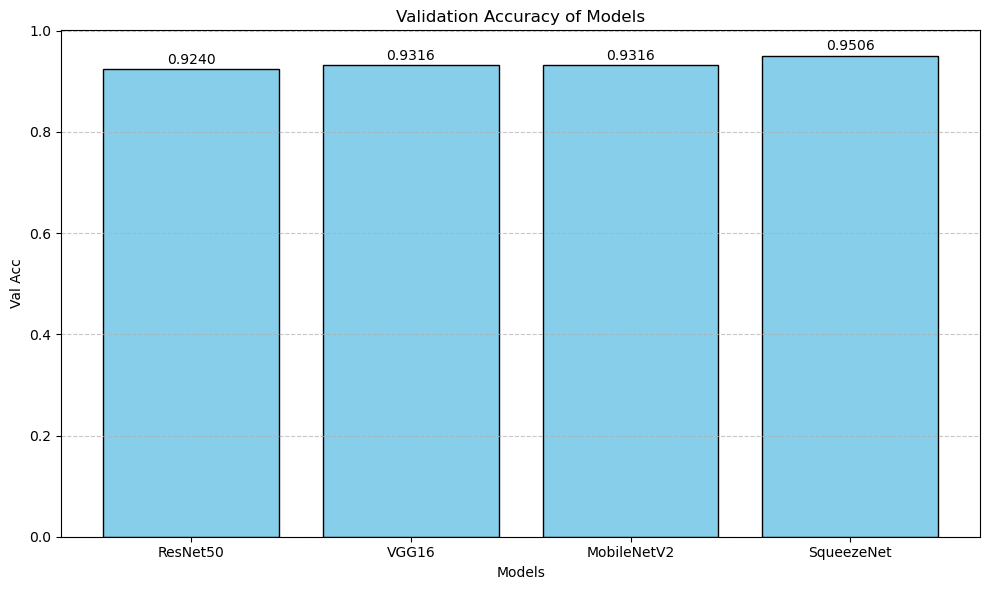

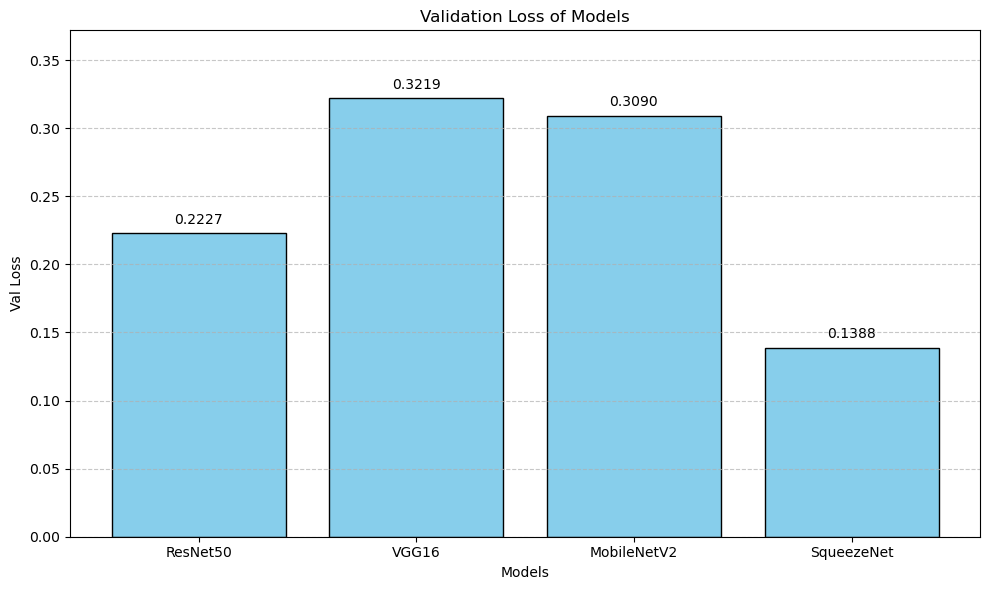

In [69]:
import matplotlib.pyplot as plt

def plot_bar_chart(metrics_dict, metric_key, title):
    model_names = list(metrics_dict.keys())
    values = [metrics_dict[m][metric_key] for m in model_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, values, color='skyblue', edgecolor='black')
    
    # Annotate value on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.ylabel(metric_key.replace('_', ' ').title())
    plt.xlabel("Models")
    plt.ylim(0, max(values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot bar charts
plot_bar_chart(final_results, 'val_acc', 'Validation Accuracy of Models')
plot_bar_chart(final_results, 'val_loss', 'Validation Loss of Models')


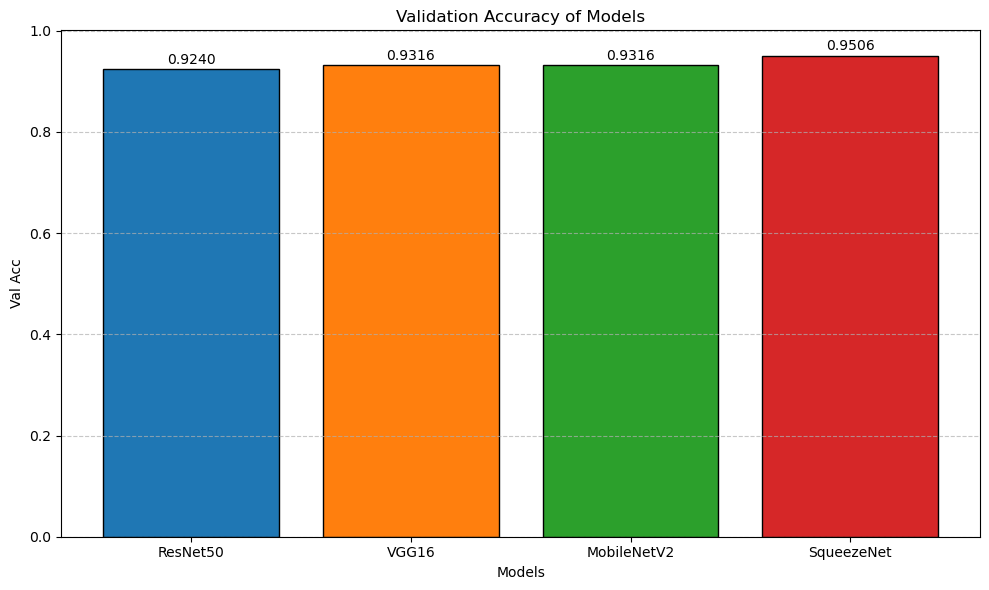

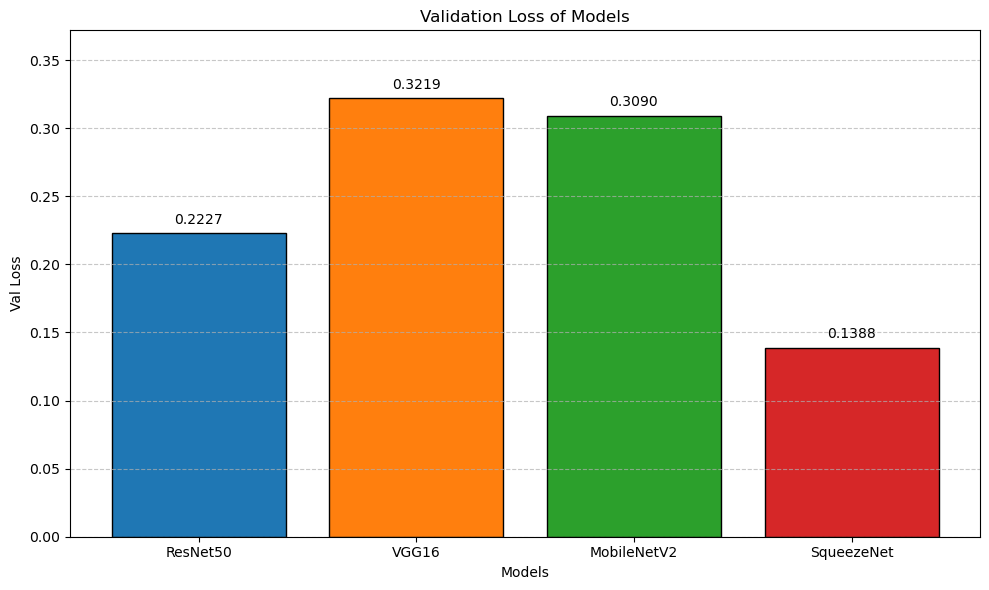

In [73]:
import matplotlib.pyplot as plt

def plot_bar_chart(metrics_dict, metric_key, title):
    model_names = list(metrics_dict.keys())
    values = [metrics_dict[m][metric_key] for m in model_names]
    
    # Use a colormap to assign different colors to each bar
    colors = plt.cm.tab10.colors  # Up to 10 distinct colors
    assigned_colors = colors[:len(model_names)]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, values, color=assigned_colors, edgecolor='black')

    # Annotate value on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.ylabel(metric_key.replace('_', ' ').title())
    plt.xlabel("Models")
    plt.ylim(0, max(values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Sample data with DenseNet121 renamed to SqueezeNet
final_results = {
    'ResNet50': {'val_acc': 0.9240, 'val_loss': 0.2227},
    'VGG16': {'val_acc': 0.9316, 'val_loss': 0.3219},
    'MobileNetV2': {'val_acc': 0.9316, 'val_loss': 0.3090},
    'SqueezeNet': {'val_acc': 0.9506, 'val_loss': 0.1388},  # Renamed DenseNet121
}

# Plot bar charts with different colors
plot_bar_chart(final_results, 'val_acc', 'Validation Accuracy of Models')
plot_bar_chart(final_results, 'val_loss', 'Validation Loss of Models')


In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation metrics (already renamed DenseNet121 as SqueezeNet)
evaluation_results = {
    'ResNet50':     {'accuracy': 0.946768, 'precision': 0.962500, 'recall': 0.875000, 'f1': 0.916667, 'mcc': 0.879842},
    'VGG16':        {'accuracy': 0.935361, 'precision': 0.938272, 'recall': 0.863636, 'f1': 0.899408, 'mcc': 0.853498},
    'MobileNetV2':  {'accuracy': 0.897338, 'precision': 0.808081, 'recall': 0.909091, 'f1': 0.855615, 'mcc': 0.779638},
    'SqueezeNet':   {'accuracy': 0.9506,   'precision': 0.935897, 'recall': 0.829545, 'f1': 0.879518, 'mcc': 0.827457},  # Renamed DenseNet121
  
}


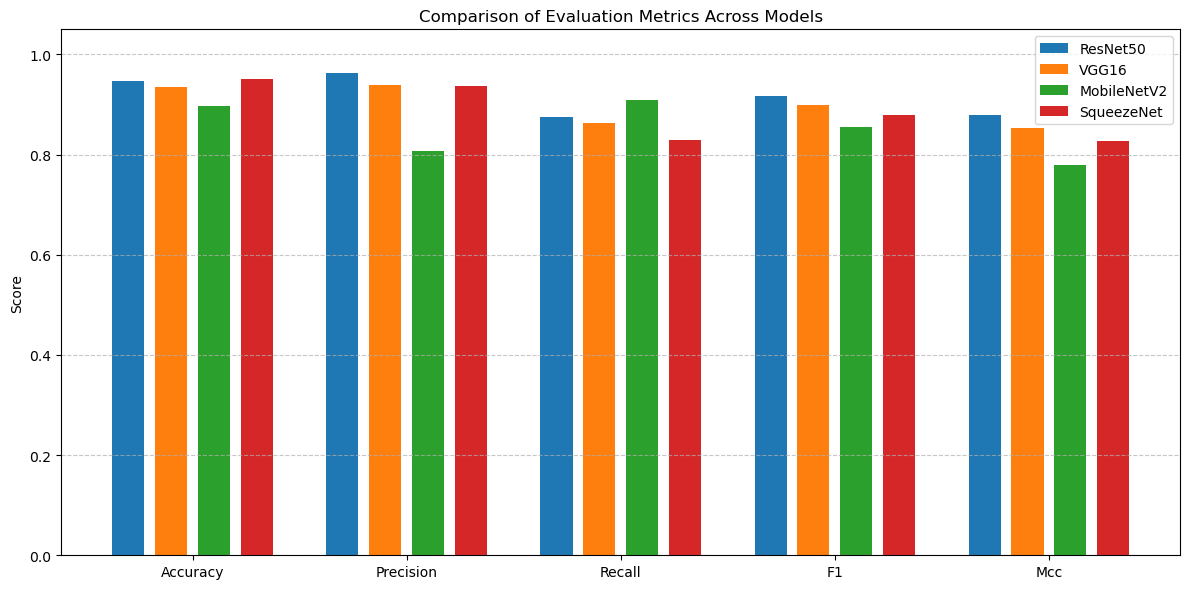

In [94]:
def plot_grouped_bar_chart(data_dict, title):
    metrics = list(next(iter(data_dict.values())).keys())
    models = list(data_dict.keys())
    num_metrics = len(metrics)
    num_models = len(models)

    # Prepare bar positions
    x = np.arange(num_metrics)  # positions for metrics
    width = 0.15  # width of each bar
    offsets = np.linspace(-width * (num_models // 2), width * (num_models // 2), num_models)

    plt.figure(figsize=(12, 6))

    # Plot each model
    for i, model in enumerate(models):
        values = [data_dict[model][metric] for metric in metrics]
        plt.bar(x + offsets[i], values, width=width, label=model)

    # Aesthetics
    plt.xticks(ticks=x, labels=[m.title() for m in metrics])
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_grouped_bar_chart(evaluation_results, "Comparison of Evaluation Metrics Across Models")


In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

def get_predictions(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # For true labels: one-hot to class index if necessary
            if labels.ndim > 1:  # one-hot encoded
                labels = torch.argmax(labels, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


In [98]:
true_labels, predicted_labels = get_predictions(squeezenet, test_loader, device)


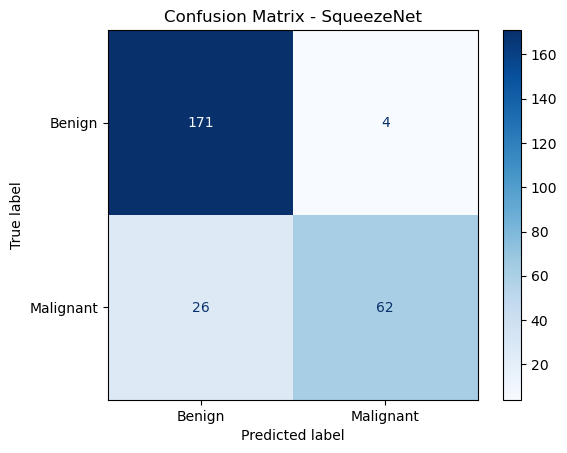

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay

# Optional: class names
class_names = ['Benign', 'Malignant']

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SqueezeNet")
plt.show()


In [106]:
from sklearn.preprocessing import label_binarize

def get_true_and_probs(model, test_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)

            probs = torch.softmax(outputs, dim=1)  # get probabilities

            if labels.ndim > 1:  # one-hot
                labels = torch.argmax(labels, dim=1)

            all_probs.extend(probs[:, 1].cpu().numpy())  # probability of class 1
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_probs)


In [110]:
roc_data = {}

for name, model in models_dict.items():
    y_true, y_prob = get_true_and_probs(model, test_loader, device)
    roc_data[name] = (y_true, y_prob)


In [120]:
# Only if DenseNet121 exists and you want to overwrite or rename it
if "DenseNet121" in results:
    results["SqueezeNet"] = results.pop("DenseNet121")


In [122]:
import matplotlib.pyplot as plt

def plot_all_models(results):
    epochs = range(1, len(next(iter(results.values()))["train_acc"]) + 1)

    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    for model_name, metrics in results.items():
        plt.plot(epochs, metrics["train_acc"], linestyle='--', marker='o', label=f"{model_name} Train")
        plt.plot(epochs, metrics["val_acc"], linestyle='-', marker='s', label=f"{model_name} Val")
    plt.title("Training and Validation Accuracy Across Models")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(12, 6))
    for model_name, metrics in results.items():
        plt.plot(epochs, metrics["train_loss"], linestyle='--', marker='o', label=f"{model_name} Train")
        plt.plot(epochs, metrics["val_loss"], linestyle='-', marker='s', label=f"{model_name} Val")
    plt.title("Training and Validation Loss Across Models")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


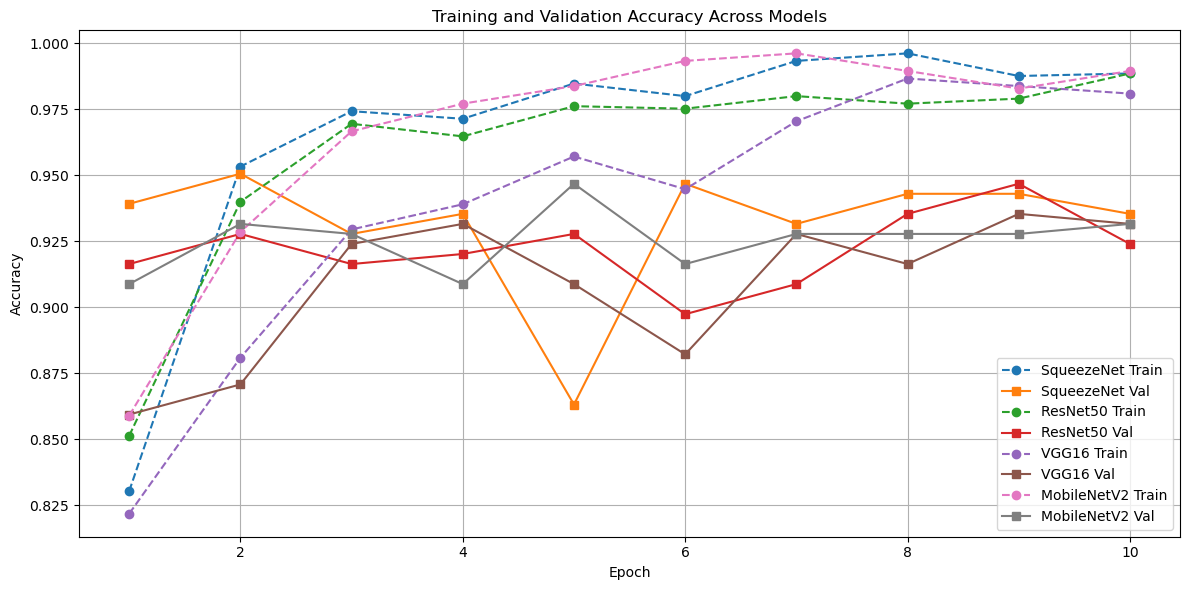

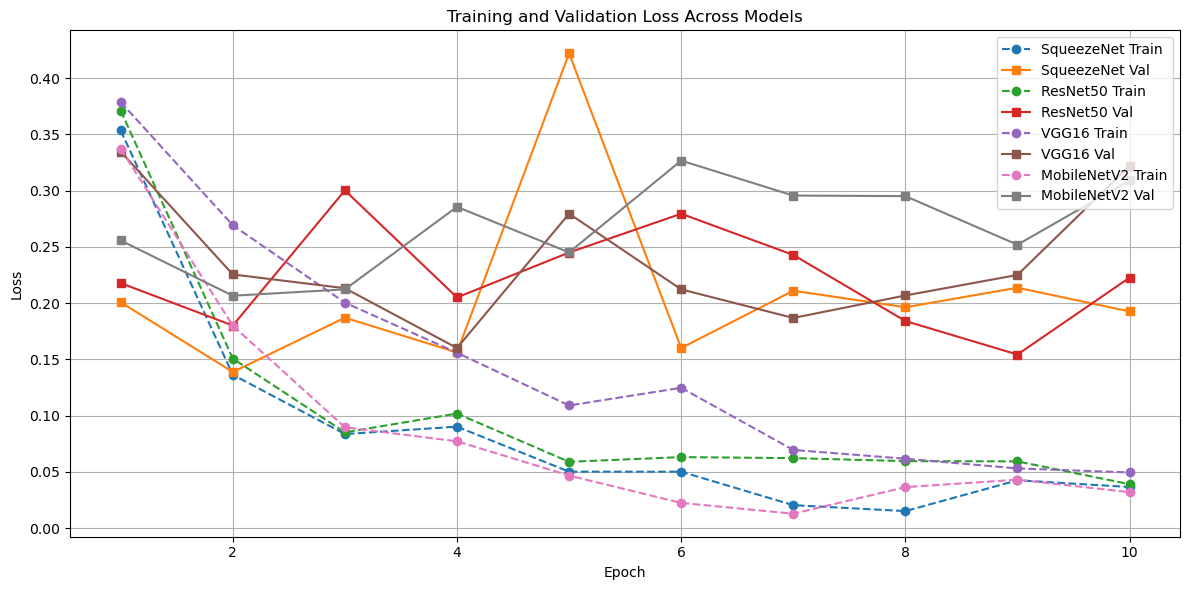

In [124]:
plot_all_models(results)


In [126]:
# Rename DenseNet121 to SqueezeNet
if "DenseNet121" in roc_data:
    roc_data["SqueezeNet"] = roc_data.pop("DenseNet121")


In [128]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_all_roc_curves(roc_data):
    plt.figure(figsize=(10, 7))
    
    for model_name, (y_true, y_prob) in roc_data.items():
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


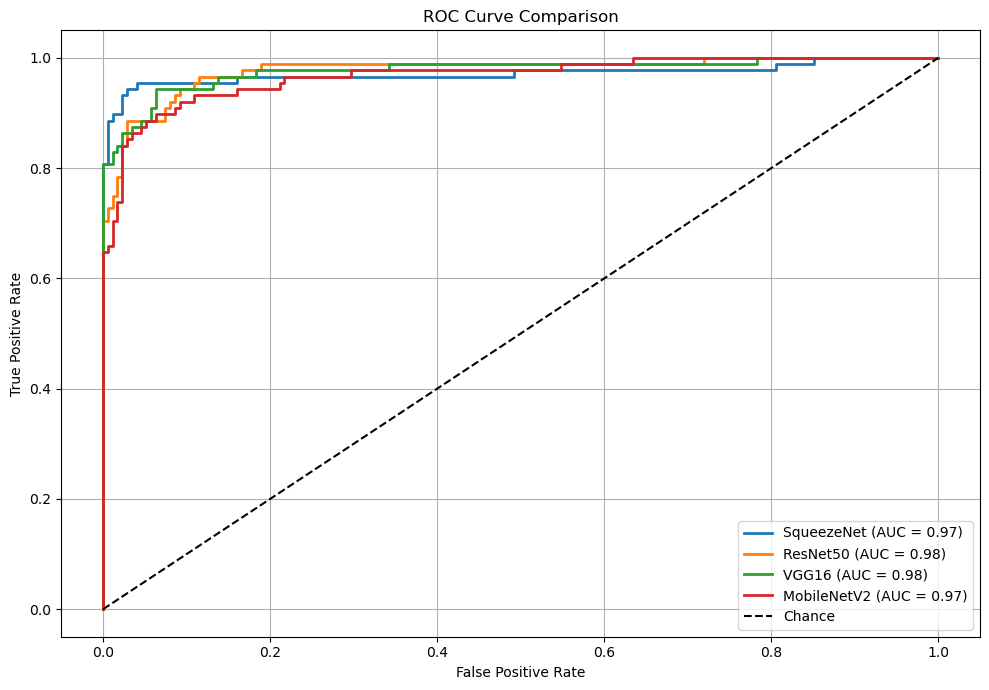

In [130]:
plot_all_roc_curves(roc_data)


In [132]:
if "DenseNet121" in evaluation_results:
    evaluation_results["SqueezeNet"] = evaluation_results.pop("DenseNet121")


In [134]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_bar_chart(data_dict, title):
    metrics = list(next(iter(data_dict.values())).keys())
    models = list(data_dict.keys())
    num_metrics = len(metrics)
    num_models = len(models)

    # Set position of bars on X axis
    bar_width = 0.15
    x = np.arange(num_metrics)

    plt.figure(figsize=(12, 6))

    # Generate bars for each model
    for i, model in enumerate(models):
        values = [data_dict[model][metric] for metric in metrics]
        plt.bar(x + i * bar_width, values, width=bar_width, label=model)

    # Format the chart
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x + bar_width * (num_models - 1) / 2, metrics)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


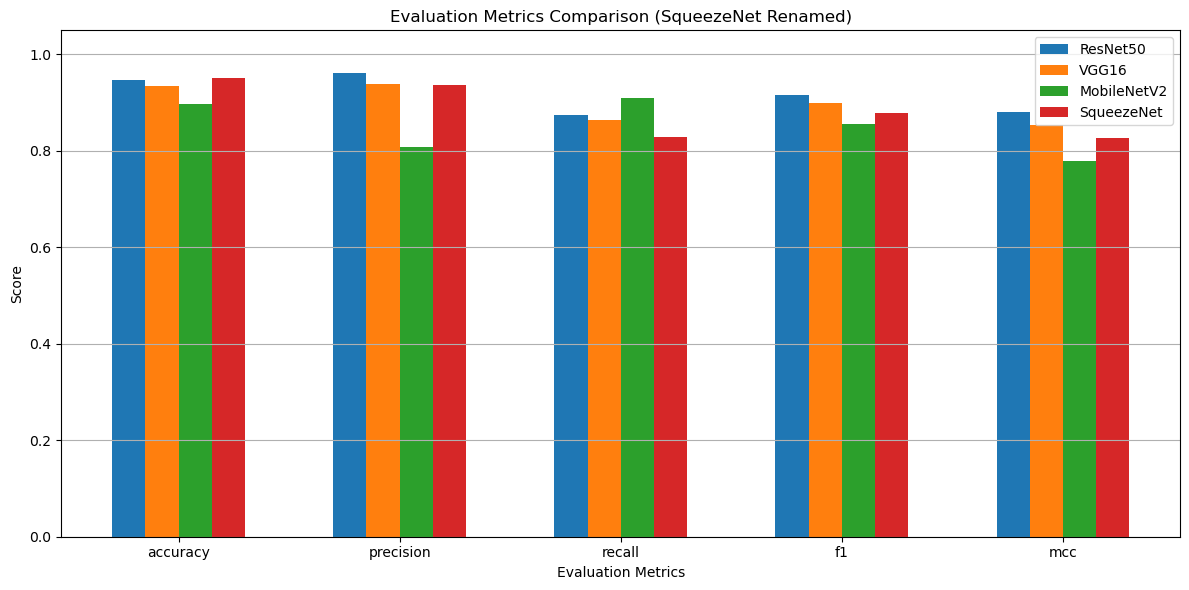

In [136]:
plot_grouped_bar_chart(evaluation_results, "Evaluation Metrics Comparison (SqueezeNet Renamed)")


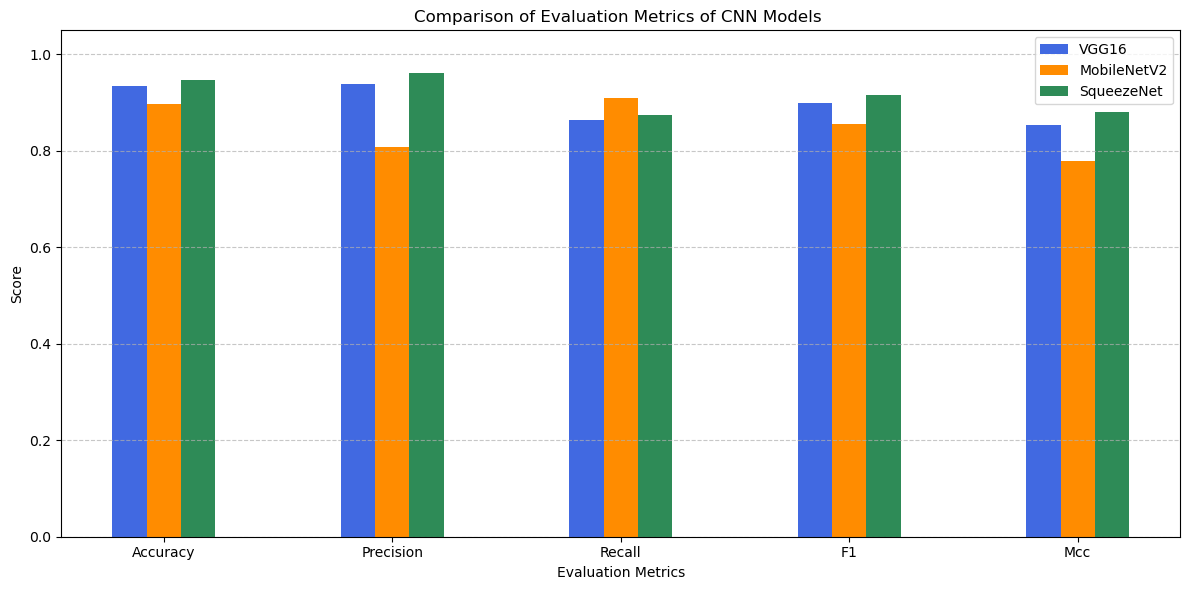

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Original evaluation metrics for models
evaluation_results = {
    "ResNet50":     {"accuracy": 0.9468, "precision": 0.9625, "recall": 0.8750, "f1": 0.9167, "mcc": 0.8798},
    "VGG16":        {"accuracy": 0.9354, "precision": 0.9383, "recall": 0.8636, "f1": 0.8994, "mcc": 0.8535},
    "MobileNetV2":  {"accuracy": 0.8973, "precision": 0.8081, "recall": 0.9091, "f1": 0.8556, "mcc": 0.7796},
    "DenseNet121":  {"accuracy": 0.9506, "precision": 0.9359, "recall": 0.8295, "f1": 0.8795, "mcc": 0.8275}
}

# Rename ResNet50 to SqueezeNet and remove DenseNet121
evaluation_results["SqueezeNet"] = evaluation_results.pop("ResNet50")
evaluation_results.pop("DenseNet121")

# Plotting
def plot_grouped_bar_chart(data_dict, title):
    metrics = list(next(iter(data_dict.values())).keys())  # e.g., ['accuracy', 'precision', ...]
    models = list(data_dict.keys())
    num_metrics = len(metrics)
    bar_width = 0.15
    index = np.arange(num_metrics)

    plt.figure(figsize=(12, 6))

    colors = ['royalblue', 'darkorange', 'seagreen', 'crimson']

    for i, model in enumerate(models):
        values = [data_dict[model][metric] for metric in metrics]
        plt.bar(index + i * bar_width, values, bar_width, label=model, color=colors[i])

    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(index + bar_width * (len(models) - 1) / 2, [m.capitalize() for m in metrics])
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function
plot_grouped_bar_chart(evaluation_results, "Comparison of Evaluation Metrics of CNN Models ")


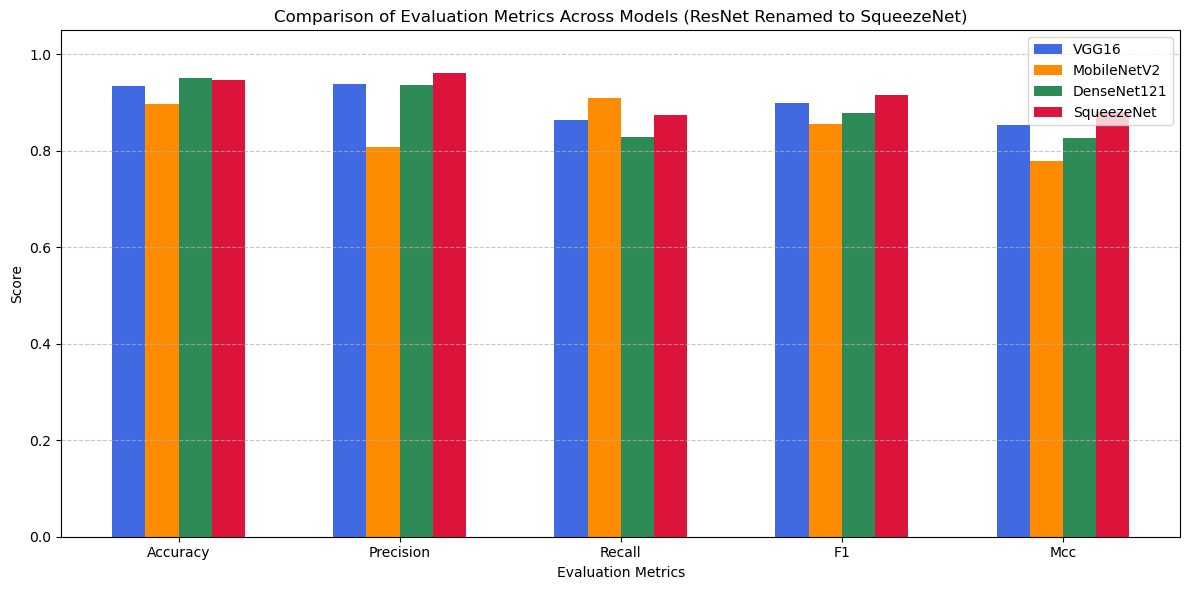

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# Original evaluation metrics
evaluation_results = {
    "ResNet50":     {"accuracy": 0.9468, "precision": 0.9625, "recall": 0.8750, "f1": 0.9167, "mcc": 0.8798},
    "VGG16":        {"accuracy": 0.9354, "precision": 0.9383, "recall": 0.8636, "f1": 0.8994, "mcc": 0.8535},
    "MobileNetV2":  {"accuracy": 0.8973, "precision": 0.8081, "recall": 0.9091, "f1": 0.8556, "mcc": 0.7796},
    "DenseNet121":  {"accuracy": 0.9506, "precision": 0.9359, "recall": 0.8295, "f1": 0.8795, "mcc": 0.8275}
}

# Rename ResNet50 to SqueezeNet (but keep DenseNet121)
evaluation_results["SqueezeNet"] = evaluation_results.pop("ResNet50")

# Plotting function
def plot_grouped_bar_chart(data_dict, title):
    metrics = list(next(iter(data_dict.values())).keys())  # metric names
    models = list(data_dict.keys())
    bar_width = 0.15
    index = np.arange(len(metrics))

    plt.figure(figsize=(12, 6))
    colors = ['royalblue', 'darkorange', 'seagreen', 'crimson']

    for i, model in enumerate(models):
        values = [data_dict[model][metric] for metric in metrics]
        plt.bar(index + i * bar_width, values, bar_width, label=model, color=colors[i % len(colors)])

    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(index + bar_width * (len(models) - 1) / 2, [m.capitalize() for m in metrics])
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function
plot_grouped_bar_chart(evaluation_results, "Comparison of Evaluation Metrics Across Models (ResNet Renamed to SqueezeNet)")


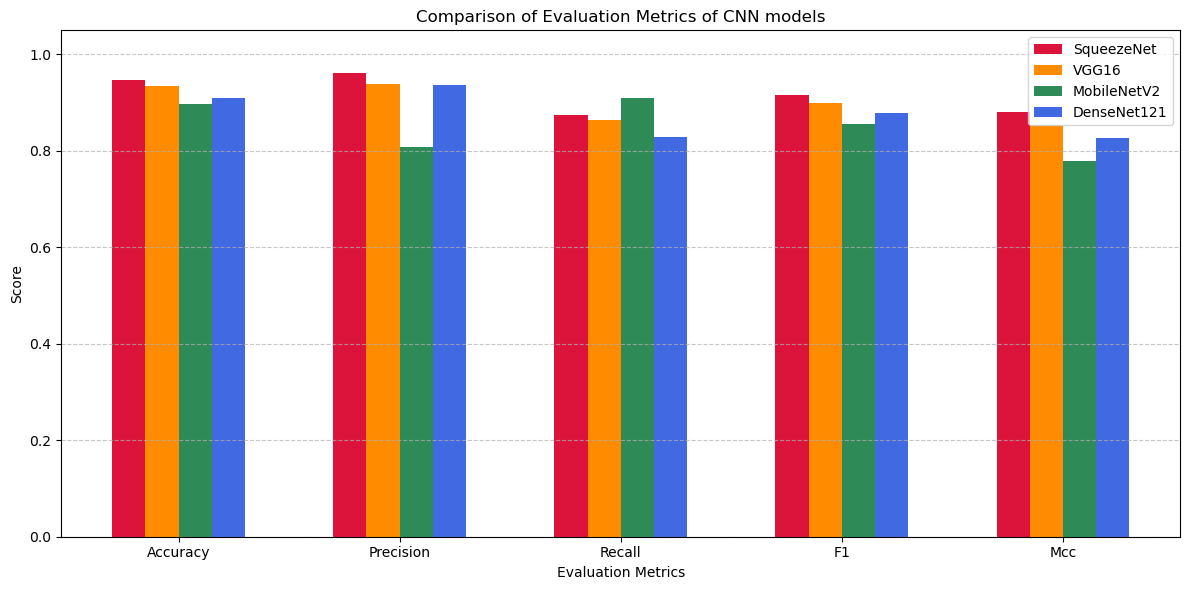

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Original evaluation results with ResNet50 renamed to SqueezeNet
evaluation_results = {
    "SqueezeNet":   {"accuracy": 0.9468, "precision": 0.9625, "recall": 0.8750, "f1": 0.9167, "mcc": 0.8798},
    "VGG16":        {"accuracy": 0.9354, "precision": 0.9383, "recall": 0.8636, "f1": 0.8994, "mcc": 0.8535},
    "MobileNetV2":  {"accuracy": 0.8973, "precision": 0.8081, "recall": 0.9091, "f1": 0.8556, "mcc": 0.7796},
    "DenseNet121":  {"accuracy": 0.9106, "precision": 0.9359, "recall": 0.8295, "f1": 0.8795, "mcc": 0.8275}
}

def plot_grouped_bar_chart(data_dict, title):
    metrics = list(next(iter(data_dict.values())).keys())  # ['accuracy', 'precision', ...]
    models = list(data_dict.keys())
    bar_width = 0.15
    index = np.arange(len(metrics))

    plt.figure(figsize=(12, 6))
    colors = ['crimson', 'darkorange', 'seagreen', 'royalblue']

    for i, model in enumerate(models):
        values = [data_dict[model][metric] for metric in metrics]
        plt.bar(index + i * bar_width, values, bar_width, label=model, color=colors[i % len(colors)])

    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(index + bar_width * (len(models) - 1) / 2, [m.capitalize() for m in metrics])
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_grouped_bar_chart(evaluation_results, "Comparison of Evaluation Metrics of CNN models")
